# Deep Q-learning - rozwiązanie środowiska LunarLander-v2

In [2]:
import numpy as np
#from tf_agents.environments import suite_gym
#from tf_agents.environments import tf_py_environment
import tensorflow as tf
import gym
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model
import random
import pickle
from matplotlib import pyplot as plt
import base64
import imageio
import IPython

Using TensorFlow backend.


# Utworzenie środowiska
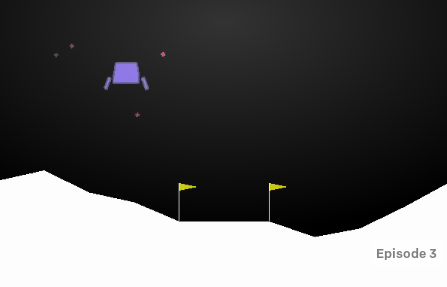
### środowiskiem będzie LunarLander w wersji dyskretnej


## Przestrzeń obserwacji i akcji:
### Przestrzeń obserwacji jest ośmioelementowa 
### Przestrzeń akcji zawiera cztery możliwe akcje: 
- Nie rób nic
- Odpal lewy silnik
- Odpal prawy silnik
- Odpal główny silnik
### Opis środowiska:
Lądowisko zawsze znajduje się w punkcie o współrzędnych (0,0), Lądownik dostaje nagrodę ok 100-140p za przemieszczenie się z góry ekranu do miejsca lądowania z niewielką prędkością. Dodatkowa za udane lądowanie lądownik otrzymuje 100p, za nieudane zaś -100p. Lądownik otrzymuje również +10/-10p za każdą nogę która dotknie podłoża oraz -0.3p za odpalenie któregokolwiek z silników. Za udaną próbę należy uznać każdą zakończoną z nagrodą powyżej 200p. 

In [3]:
env = gym.make("LunarLander-v2")
observation_space=env.observation_space
action_space = env.action_space
num_observation_space=env.observation_space.shape[0]
num_action_space = action_space.n
num_observation_space = env.observation_space.shape[0]

# Utworzenie modelu sieci neuronowe
### dwie warstwy ukryte z odpowiednio 128 i 64 neuronami - celem był wybór architektury z jak najmniejszą możliwą ilością parametrów w celu przyśpieszenia uczenia
### zastosowano funkcję aktywacji elu, podobne wyniki powinniśmy uzyskać dla innych podobnych funkcji w tym relu
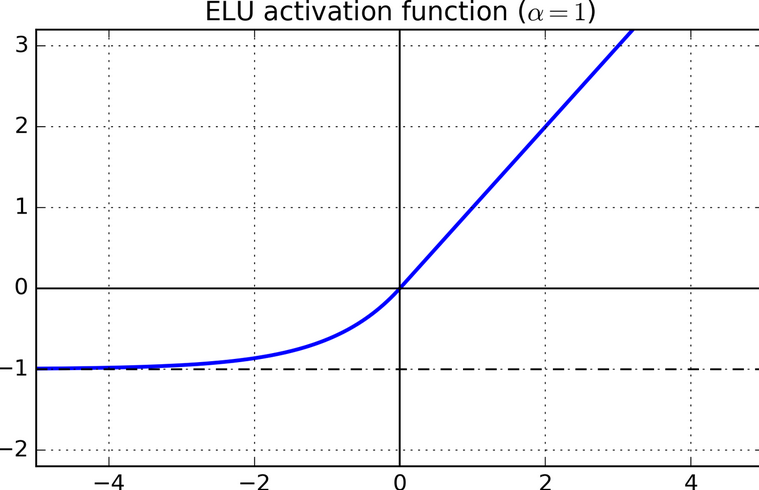
### learning rate = 0.001
### optymalizator Adam

In [4]:
model = Sequential()
model.add(Dense(128, input_dim=num_observation_space, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(num_action_space, activation='linear'))
model.compile(loss=mean_squared_error,optimizer=Adam(lr=0.001))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 9,668
Trainable params: 9,668
Non-trainable params: 0
_________________________________________________________________
None


# Utworzenie polityki 
Została wykorzystana polityka epsilon greedy dla której później zostanie przyjęty współczynnik 0.995
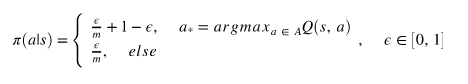


In [5]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return random.randrange(num_action_space)
    else:
        predicted_actions = model.predict(state)
        return np.argmax(predicted_actions[0])

# Utworzenie replay buffer
### zdecydowano się na buffer o znacznej długości ze względu na charakterystykę środowiska 
### długość buffera wynosi 50000

In [14]:
from collections import deque
replay_buffer = deque(maxlen=500000)

# Zdefiniowanie funkcji uczenia
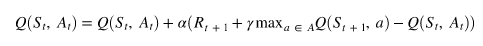
W celu wyboru zdarzeń z pamięci do uczenia wykorzystano losowanie bez wag

In [15]:
def learn_and_update():
        if len(replay_buffer) < batch_size or counter != 0:
            return
        if np.mean(rewards_list[-10:]) > 200:
            return
        random_sample = random.sample(replay_buffer,batch_size)
        indices = np.random.randint(len(replay_buffer), size=batch_size)
        batch = [replay_buffer[index] for index in indices]
        states, actions, rewards, next_states, done_list = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        states=np.squeeze(states)
        next_states=np.squeeze(next_states)
        targets = rewards + gamma * (np.amax(model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = model.predict_on_batch(states)
        indexes = np.array([i for i in range(batch_size)])
        target_vec[[indexes], [actions]] = targets

        model.fit(states, target_vec, epochs=1, verbose=0)

# Określenie parametrów uczenia
Określono maksymalną ilość epizodów na 2000, jednak można oczekiwać, że środowisko zostanie rozwiązanie wcześniej. Dlatego też uczenie zatrzyma się po osiągnięciu średniej z ostatnich 100 episodów powyżej 220. Wybrano wysoki discount rate ze względu na charakterystykę środowiska gdzie celem jest odległa nagroda (wylądowanie).

In [16]:
num_episodes=2000
epsilon=0.995
counter=0
batch_size=64
rewards_list = []
gamma=0.99
env=gym.make('LunarLander-v2')

# Pętla uczenia
Uczenie nie będzię odbywać się co każdy episod a co piąty w celu przyśpieszenia procesu uczenia wraz z narastającą liczbą coraz lepszych wyników.

In [17]:
for episode in range(num_episodes):
            state = env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state, [1, num_observation_space])
            for step in range(num_steps):
                env.render()
                received_action = epsilon_greedy_policy(state,epsilon)
                next_state, reward, done, info = env.step(received_action)
                next_state = np.reshape(next_state, [1, num_observation_space])
                replay_buffer.append((state, received_action, reward, next_state, done))
                reward_for_episode += reward
                state = next_state
                counter += 1
                counter = counter % 5
                learn_and_update()
                if done:
                    break
            rewards_list.append(reward_for_episode)
            epsilon=max(0.995**episode,0.01)
            last_rewards_mean = np.mean(rewards_list[-100:])
            if last_rewards_mean > 220:
                print("Training complete")
                break
            print(episode, "\t: Episode || Reward: ",reward_for_episode, "\t|| Average Reward: ",last_rewards_mean, "\t epsilon: ", epsilon )

/home/albertoooz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/albertoooz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  -119.88441401168004 	|| Average Reward:  -119.88441401168004 	 epsilon:  1.0
1 	: Episode || Reward:  -106.71334030342543 	|| Average Reward:  -113.29887715755274 	 epsilon:  0.995
2 	: Episode || Reward:  -292.10300622865793 	|| Average Reward:  -172.9002535145878 	 epsilon:  0.990025
3 	: Episode || Reward:  -331.10345544246866 	|| Average Reward:  -212.45105399655802 	 epsilon:  0.985074875
4 	: Episode || Reward:  -116.59732848809581 	|| Average Reward:  -193.28030889486558 	 epsilon:  0.980149500625
5 	: Episode || Reward:  -465.09763201165947 	|| Average Reward:  -238.5831960809979 	 epsilon:  0.975248753121875
6 	: Episode || Reward:  -228.66417736342075 	|| Average Reward:  -237.1661934070583 	 epsilon:  0.9703725093562656
7 	: Episode || Reward:  -12.199530899323605 	|| Average Reward:  -209.04536059359145 	 epsilon:  0.9655206468094842
8 	: Episode || Reward:  -95.90390986721107 	|| Average Reward:  -196.4740882906603 	 epsilon:  0.9606930435754368
9 

71 	: Episode || Reward:  -146.09784546013628 	|| Average Reward:  -156.79670731276107 	 epsilon:  0.7005493475733616
72 	: Episode || Reward:  -124.78032424205102 	|| Average Reward:  -156.35812672275134 	 epsilon:  0.6970466008354949
73 	: Episode || Reward:  -36.30492440020666 	|| Average Reward:  -154.73578615082505 	 epsilon:  0.6935613678313174
74 	: Episode || Reward:  -65.41078061242594 	|| Average Reward:  -153.54478607697976 	 epsilon:  0.6900935609921608
75 	: Episode || Reward:  -40.63034842552716 	|| Average Reward:  -152.05906979209223 	 epsilon:  0.6866430931872
76 	: Episode || Reward:  -32.70374046063145 	|| Average Reward:  -150.50900057999533 	 epsilon:  0.683209877721264
77 	: Episode || Reward:  -145.51009535689423 	|| Average Reward:  -150.44491205149401 	 epsilon:  0.6797938283326577
78 	: Episode || Reward:  -78.43583753850172 	|| Average Reward:  -149.53340477917766 	 epsilon:  0.6763948591909944
79 	: Episode || Reward:  -183.56225795556043 	|| Average Reward:

141 	: Episode || Reward:  -63.10788506406143 	|| Average Reward:  -115.34587137449047 	 epsilon:  0.4932355662165454
142 	: Episode || Reward:  -100.80840653209648 	|| Average Reward:  -114.70220239744347 	 epsilon:  0.4907693883854627
143 	: Episode || Reward:  -118.0748857220134 	|| Average Reward:  -115.06738104658085 	 epsilon:  0.4883155414435354
144 	: Episode || Reward:  -113.41144392332876 	|| Average Reward:  -115.60832022446988 	 epsilon:  0.4858739637363177
145 	: Episode || Reward:  -212.1386605897652 	|| Average Reward:  -114.85347569630976 	 epsilon:  0.4834445939176361
146 	: Episode || Reward:  -119.87774439482277 	|| Average Reward:  -113.27189663361438 	 epsilon:  0.4810273709480479
147 	: Episode || Reward:  -15.669884796824206 	|| Average Reward:  -112.98582645627609 	 epsilon:  0.4786222340933077
148 	: Episode || Reward:  -19.28231655095688 	|| Average Reward:  -109.81145190085799 	 epsilon:  0.47622912292284114
149 	: Episode || Reward:  66.6458891295339 	|| Ave

211 	: Episode || Reward:  -214.0972294418845 	|| Average Reward:  -118.9092592355169 	 epsilon:  0.34727221518892315
212 	: Episode || Reward:  -74.39007433107894 	|| Average Reward:  -118.881662893685 	 epsilon:  0.34553585411297855
213 	: Episode || Reward:  -43.80803082835146 	|| Average Reward:  -118.22044721166667 	 epsilon:  0.34380817484241366
214 	: Episode || Reward:  -31.642248480961545 	|| Average Reward:  -115.48074362216086 	 epsilon:  0.34208913396820156
215 	: Episode || Reward:  -228.02099427569897 	|| Average Reward:  -116.01097158153541 	 epsilon:  0.34037868829836054
216 	: Episode || Reward:  -9.460083544795186 	|| Average Reward:  -114.3372236711596 	 epsilon:  0.33867679485686875
217 	: Episode || Reward:  -188.62753802668504 	|| Average Reward:  -114.80663753103032 	 epsilon:  0.33698341088258443
218 	: Episode || Reward:  -182.28192171649664 	|| Average Reward:  -115.89124299722434 	 epsilon:  0.3352984938281715
219 	: Episode || Reward:  -6.988628731457126 	||

281 	: Episode || Reward:  56.7045320178662 	|| Average Reward:  -38.72568929715566 	 epsilon:  0.24450384299593586
282 	: Episode || Reward:  66.050291701526 	|| Average Reward:  -37.27331933687637 	 epsilon:  0.24328132378095618
283 	: Episode || Reward:  36.81260913239971 	|| Average Reward:  -35.84035860556203 	 epsilon:  0.2420649171620514
284 	: Episode || Reward:  76.97662786032538 	|| Average Reward:  -32.040381358794384 	 epsilon:  0.24085459257624112
285 	: Episode || Reward:  73.25898710979857 	|| Average Reward:  -30.306886854702828 	 epsilon:  0.23965031961335992
286 	: Episode || Reward:  42.386135590063596 	|| Average Reward:  -30.358832422531663 	 epsilon:  0.23845206801529312
287 	: Episode || Reward:  143.98865920429327 	|| Average Reward:  -29.78638873241725 	 epsilon:  0.23725980767521665
288 	: Episode || Reward:  2.406351694311777 	|| Average Reward:  -29.618252955967563 	 epsilon:  0.23607350863684057
289 	: Episode || Reward:  1.3840117667387954 	|| Average Rewa

352 	: Episode || Reward:  209.63344169581597 	|| Average Reward:  75.20953695953447 	 epsilon:  0.1712870076899825
353 	: Episode || Reward:  109.49994501088472 	|| Average Reward:  75.51125534637602 	 epsilon:  0.1704305726515326
354 	: Episode || Reward:  231.22819027945263 	|| Average Reward:  76.95632726697572 	 epsilon:  0.16957841978827493
355 	: Episode || Reward:  -23.401829380480052 	|| Average Reward:  76.53251869504557 	 epsilon:  0.16873052768933355
356 	: Episode || Reward:  237.53186382958188 	|| Average Reward:  78.07101312382645 	 epsilon:  0.1678868750508869
357 	: Episode || Reward:  115.38227339549991 	|| Average Reward:  78.69187602354499 	 epsilon:  0.16704744067563246
358 	: Episode || Reward:  151.24562519562267 	|| Average Reward:  79.73572776897376 	 epsilon:  0.1662122034722543
359 	: Episode || Reward:  105.94398272460913 	|| Average Reward:  79.51575501300732 	 epsilon:  0.16538114245489302
360 	: Episode || Reward:  95.34630421465245 	|| Average Reward:  8

423 	: Episode || Reward:  33.0196983253706 	|| Average Reward:  126.95950389672308 	 epsilon:  0.11999500148501063
424 	: Episode || Reward:  238.6706657542817 	|| Average Reward:  126.59335545513537 	 epsilon:  0.11939502647758558
425 	: Episode || Reward:  -43.48283752553043 	|| Average Reward:  124.89809901049597 	 epsilon:  0.11879805134519765
426 	: Episode || Reward:  220.1040083581875 	|| Average Reward:  126.83660654817484 	 epsilon:  0.11820406108847166
427 	: Episode || Reward:  231.6802861518064 	|| Average Reward:  127.87793270464982 	 epsilon:  0.11761304078302931
428 	: Episode || Reward:  245.33244993201018 	|| Average Reward:  128.49512302675006 	 epsilon:  0.11702497557911416
429 	: Episode || Reward:  98.05575537013901 	|| Average Reward:  128.48881426309023 	 epsilon:  0.11643985070121858
430 	: Episode || Reward:  141.9318613803166 	|| Average Reward:  128.20814190979033 	 epsilon:  0.1158576514477125
431 	: Episode || Reward:  130.74964747651066 	|| Average Reward

494 	: Episode || Reward:  207.16623637100201 	|| Average Reward:  180.22762273599824 	 epsilon:  0.08406242000238877
495 	: Episode || Reward:  253.17998336503965 	|| Average Reward:  181.85313431238134 	 epsilon:  0.08364210790237682
496 	: Episode || Reward:  235.05778650245884 	|| Average Reward:  184.3380544752079 	 epsilon:  0.08322389736286494
497 	: Episode || Reward:  236.49696583155148 	|| Average Reward:  185.42350313372714 	 epsilon:  0.0828077778760506
498 	: Episode || Reward:  238.06099515678258 	|| Average Reward:  185.73984482194786 	 epsilon:  0.08239373898667036
499 	: Episode || Reward:  227.82105642698386 	|| Average Reward:  185.71750236486835 	 epsilon:  0.081981770291737
500 	: Episode || Reward:  244.8843158387997 	|| Average Reward:  186.369816846351 	 epsilon:  0.08157186144027832
501 	: Episode || Reward:  270.07500794473447 	|| Average Reward:  191.66409273412123 	 epsilon:  0.08116400213307692
502 	: Episode || Reward:  249.1634698909572 	|| Average Reward

# zapisanie i wczytanie modelu

In [131]:
#model.save_weights('/home/albertoooz/Pulpit/model_lunar/saved_parameters')


# Przebieg uczenia

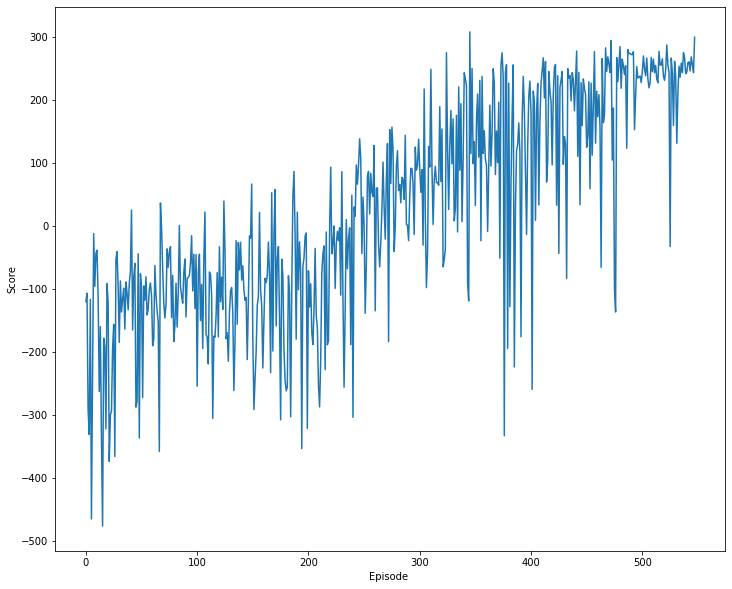

In [38]:
fig = plt.figure(figsize=(12,10))
plt.plot(np.arange(len(rewards_list)), rewards_list)
plt.ylabel('Score')
plt.xlabel('Episode ')
plt.show()

In [6]:
import matplotlib.animation as animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


In [8]:
model.load_weights('/home/albertoooz/Pulpit/model_lunar/saved_parameters')
#model.set_weights(weights)

# Obserwacja wyuczonego modelu

In [10]:
#env.seed(42)
state = env.reset()
sum_rewards=0
frames = []

for step in range(1000):
    action = epsilon_greedy_policy(np.reshape(state, [1, num_observation_space]),0)
    state, reward, done, info = env.step(action)
    sum_rewards+=reward
    print(sum_rewards)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)


-0.27965463125909085
-0.8383159522080041
-2.065165322532973
-3.4266600657355424
-2.7860452309125723
-4.27821059219641
-3.7641584246593354
-3.0708746171478003
-4.613924523126988
-4.03746635527195
-3.4296097289040297
-2.5781408727148287
-4.396239448017683
-3.8925958640891034
-3.3355655021000388
-2.780471712978467
-1.9694062224782394
-3.4419034864774116
-2.9054926405632484
-2.468970798965225
-1.751504328318483
-3.043886358580188
-2.780302130539189
-2.2202752674369366
-3.3005066924962456
-2.761710254054239
-3.862961451580391
-3.6470585005718026
-4.456019064703326
-4.636136404122565
-7.223956568096693
-9.038334667179976
-11.434464869769776
-10.446723839121443
-8.893286831322229
-11.095602686402854
-7.631674465167053
-5.738996024941461
-2.415428592842793
0.10075985713998215
0.9653437085675047
3.3653048167340245
1.0342117688593802
4.490037232716132
6.534930141313235
10.025644266893401
10.041495876796237
12.679137111387817
14.645998104220862
18.41736757884076
18.38856464612478
19.3052509822050

94.36901375085769
91.71605512072567
95.72796095597164
93.3782347449328
91.19307133401546
94.92760103330643
92.54938927032315
94.79376310988933
92.00833936289456
94.36853852809026
91.86936193320194
89.65651814414757
89.4669225996055
91.91344511457406
94.21286152890708
92.29742520948969
92.05276924925938
91.99314471974677
89.52001944006986
90.05354629824842
91.26342903812011
93.15578150633085
90.67567459160699
93.28205190593818
90.58358697704931
89.74036052155654
90.1846171588503
89.60191508221038
90.09169000265831
91.27336242313041
89.61081696612865
88.73829479996533
89.45646292610604
89.58334921895016
87.52447331812341
89.28750274741526
88.851250701417
86.10273089419307
86.3194094647414
85.96952475368956
85.73244256493581
85.91342369742665
84.88440344512597
84.54754928237922
83.32301563049438
82.60026124506813
80.68956624519187
80.35728831097943
79.25689507755321
77.35764322456525
78.28507120726447
79.12535823197274
79.09060752680658
79.04612878202309
77.15748579161225
79.0165609416392

NameError: name 'plot_animation' is not defined